In [16]:
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
env = gym.make("CartPole-v1")

In [19]:
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

NUM_EPISODES = 1000
LEARNING_RATE = 0.001
DISCOUNT_FACTOR = 0.95

In [20]:
class ReinforceNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(ReinforceNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [21]:
def discount_rewards(episode_rewards, discount_factor):
    discounted_rewards = np.zeros_like(episode_rewards)
    cumulative_reward = 0
    for i in reversed(range(len(episode_rewards))):
        cumulative_reward = episode_rewards[i] + discount_factor * cumulative_reward
        discounted_rewards[i] = cumulative_reward
    return discounted_rewards


def normalize_rewards(episode_rewards):
    return (episode_rewards - np.mean(episode_rewards)) / (
        np.std(episode_rewards) + 1e-9
    )

In [22]:
def train(
    model: nn.Module,
    optimizer: optim.Optimizer,
    device: torch.device,
    env: gym.Env,
    num_episodes: int,
    discount_factor: float,
):
    reward_history = []
    action_history = dict()
    for episode_idx in range(num_episodes):
        state, _ = env.reset()
        done = False
        step = 0
        episode_rewards, episode_log_probs, episode_actions = [], [], []
        while not done and step < 1000:
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action_log_probs = model(state).squeeze(0)
            action_probs = torch.exp(action_log_probs)
            action = np.random.choice(
                range(ACTION_SIZE), p=action_probs.detach().cpu().numpy()
            )
            next_state, reward, terminated, truncated, _ = env.step(action)
            reward += 1 - abs(next_state[0])  # Add reward based on distance from center
            done = terminated or truncated
            state = next_state

            episode_log_probs.append(action_log_probs[action])
            episode_rewards.append(reward)
            episode_actions.append(action)

        discounted_normalized_rewards = torch.tensor(
            normalize_rewards(discount_rewards(episode_rewards, discount_factor)),
            dtype=torch.float32,
            device=device,
        )
        loss = -torch.mean(
            torch.stack(episode_log_probs) * discounted_normalized_rewards
        )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        reward_history.append(sum(episode_rewards))

        if episode_idx % 50 == 0:
            print(
                f"Episode {episode_idx}, Total Reward: {sum(episode_rewards)}, Loss: {loss.item()}"
            )
        step += 1

        if episode_idx % (num_episodes // 4) == 0 or episode_idx == num_episodes - 1:
            torch.save(model.state_dict(), f"reinforce_{episode_idx}.pth")

    return reward_history, action_history

In [23]:
model = ReinforceNetwork(STATE_SIZE, ACTION_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
env = gym.make("CartPole-v1")
rewards, actions = train(model, optimizer, device, env, NUM_EPISODES, DISCOUNT_FACTOR)

Episode 0, Total Reward: 91.13861976191401, Loss: -0.0044046491384506226
Episode 50, Total Reward: 91.35409054736374, Loss: -0.0018697044579312205
Episode 100, Total Reward: 49.71275690814946, Loss: 0.0003955572610720992
Episode 150, Total Reward: 95.83362942305394, Loss: 0.006935591343790293
Episode 200, Total Reward: 34.92270375601947, Loss: 0.0014128817711025476
Episode 250, Total Reward: 102.76726497238269, Loss: 0.027471184730529785
Episode 300, Total Reward: 83.66020862158621, Loss: -0.04566369578242302
Episode 350, Total Reward: 51.89134327555075, Loss: 0.04705202206969261
Episode 400, Total Reward: 41.19125041202642, Loss: -0.0927015170454979
Episode 450, Total Reward: 103.23897632211447, Loss: -0.03228534013032913
Episode 500, Total Reward: 39.42028905329062, Loss: -0.0053462982177734375
Episode 550, Total Reward: 182.82986805750988, Loss: -0.0004950283328071237
Episode 600, Total Reward: 233.32912063748518, Loss: -0.016096072271466255
Episode 650, Total Reward: 126.7745163303

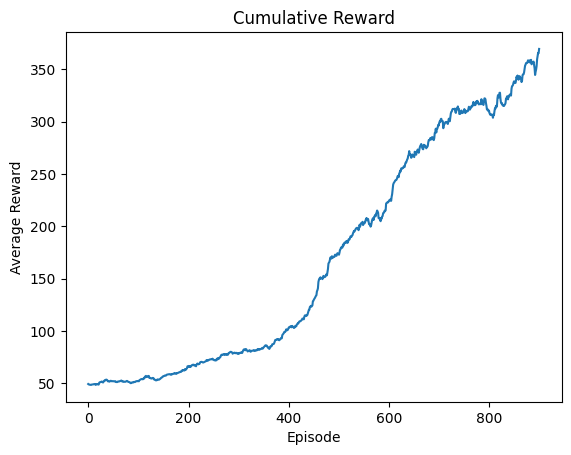

In [25]:
avg_rewards = [np.mean(rewards[i - 100 : i]) for i in range(100, len(rewards))]
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Cumulative Reward")
plt.show()

In [26]:
from pathlib import Path

for model_file in sorted(
    list(Path(".").glob("reinforce_*.pth")), key=lambda x: int(x.stem.split("_")[1])
):
    print(model_file)
    model = ReinforceNetwork(STATE_SIZE, ACTION_SIZE).to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    env = gym.make("CartPole-v1", render_mode="human")
    state, _ = env.reset()
    done = False
    while not done:
        env.render()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = torch.argmax(model(state)).item()
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        time.sleep(1 / 60)
    env.close()

reinforce_0.pth
reinforce_250.pth
reinforce_500.pth
reinforce_750.pth
reinforce_999.pth
